<a href="https://colab.research.google.com/github/Shrey-Viradiya/DiveDeep/blob/master/Prac10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir quickdraw_data
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/apple.npy ./quickdraw_data/
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy ./quickdraw_data/
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/bulldozer.npy ./quickdraw_data/
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/camouflage.npy ./quickdraw_data/
!gsutil cp "gs://quickdraw_dataset/full/numpy_bitmap/diving board.npy" ./quickdraw_data/

Copying gs://quickdraw_dataset/full/numpy_bitmap/apple.npy...
| [1 files][108.2 MiB/108.2 MiB]                                                
Operation completed over 1 objects/108.2 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy...
\ [1 files][113.4 MiB/113.4 MiB]                                                
Operation completed over 1 objects/113.4 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/bulldozer.npy...
\ [1 files][140.1 MiB/140.1 MiB]                                                
Operation completed over 1 objects/140.1 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/camouflage.npy...
\ [1 files][129.1 MiB/129.1 MiB]                                                
Operation completed over 1 objects/129.1 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/diving board.npy...
/ [1 files][217.0 M

In [2]:
!nvidia-smi

Mon Apr 26 04:28:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# GAN

In [3]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

### Load images

In [4]:
apple_images = './quickdraw_data/apple.npy'

### Discriminator Network

In [5]:
def discriminator_builder(img_w, img_h,width = 64, p = 0.4):
    
    # define inputs
    
    inputs = keras.layers.Input((img_w, img_h,1))
    
    # convolutional layers
    conv1 = keras.layers.Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = keras.layers.Dropout(p)(conv1)
    
    conv2 = keras.layers.Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = keras.layers.Dropout(p)(conv2)
    
    conv3 = keras.layers.Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = keras.layers.Dropout(p)(conv3)
    
    conv4 = keras.layers.Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = keras.layers.Flatten()(keras.layers.Dropout(p)(conv4))
    
    output = keras.layers.Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

### Generator Network

In [6]:
def generator_builder(z_dim=100,width=64,p=0.4):
    
    # Define inputs
    inputs = keras.layers.Input((z_dim,))
    
    # First dense layer
    dense1 = keras.layers.Dense(7*7*64)(inputs)
    dense1 = keras.layers.BatchNormalization(momentum = 0.9)(dense1)
    dense1 = keras.layers.Activation(activation = 'relu')(dense1)
    dense1 = keras.layers.Reshape((7,7,64))(dense1)
    dense1 = keras.layers.Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = keras.layers.UpSampling2D()(dense1)
    conv1 = keras.layers.Conv2DTranspose(int(width / 2), kernel_size = 5, padding = 'same', activation = None,)(conv1)
    conv1 = keras.layers.BatchNormalization(momentum=0.9)(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    
    conv2 = keras.layers.UpSampling2D()(conv1)
    conv2 = keras.layers.Conv2DTranspose(int(width / 4), kernel_size = 5, padding = 'same', activation = None,)(conv2)
    conv2 = keras.layers.BatchNormalization(momentum=0.9)(conv2)
    conv2 = keras.layers.Activation(activation='relu')(conv2)
    
    conv3 = keras.layers.Conv2DTranspose(int(width / 8), kernel_size = 5, padding = 'same', activation = None,)(conv2)
    conv3 = keras.layers.BatchNormalization(momentum=0.9)(conv3)
    conv3 = keras.layers.Activation(activation='relu')(conv3)
    
    output = keras.layers.Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model


### Create adversarial network¶

In [7]:
def adversarial_builder(generator, discriminator):
    model = keras.models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

### Train

In [8]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [9]:
def train(adversarial_model,data,epochs=2000,batch=128):
    
    generator, discriminator = adversarial_model.layers

    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

## Engine

In [10]:
def GAN_engine(path_to_npy):
    data = np.load(path_to_npy)

    data = data/255
    data = np.reshape(data, (data.shape[0],28,28,1))
    img_w, img_h = data.shape[1:3]

    discriminator = discriminator_builder(img_w, img_h)
    discriminator.compile(loss='binary_crossentropy', 
                      optimizer=keras.optimizers.RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])
    
    generator = generator_builder()

    adversarial_model = adversarial_builder(generator, discriminator)

    a_metrics_complete, d_metrics_complete = train(adversarial_model,data, epochs=10000)

    ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
    ).plot(title='Training Loss', logy=True)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
    ).plot(title='Training Accuracy')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

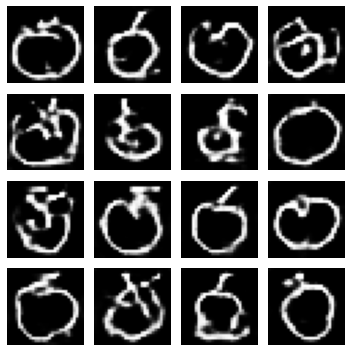

500
600
700
800
900
Epoch #1000
999: [D loss: 0.580280, acc: 0.718777]  [A loss: 1.585725, acc: 0.104863]


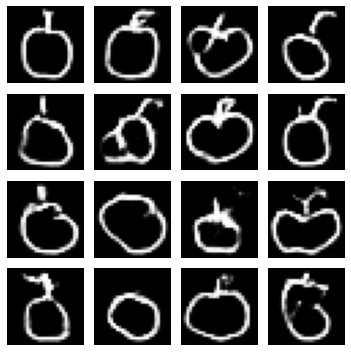

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.630574, acc: 0.674580]  [A loss: 1.424212, acc: 0.124088]


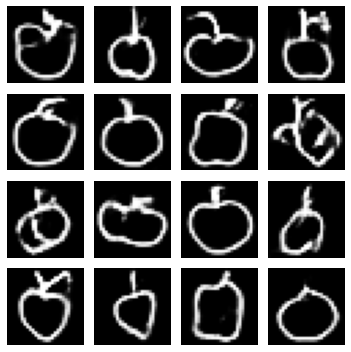

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.644306, acc: 0.655371]  [A loss: 1.315121, acc: 0.135236]


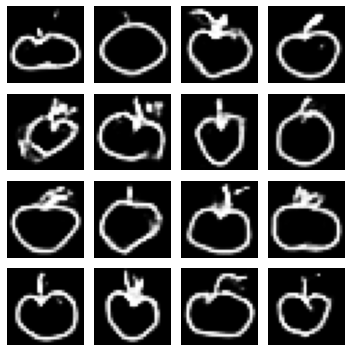

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.649961, acc: 0.647185]  [A loss: 1.271788, acc: 0.140131]


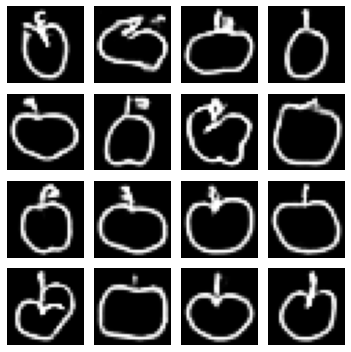

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.650518, acc: 0.645735]  [A loss: 1.269749, acc: 0.142589]


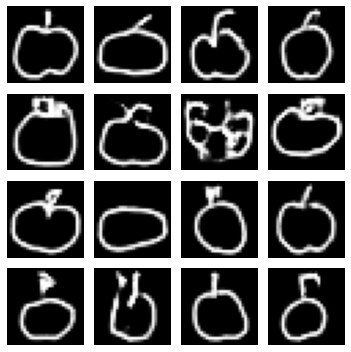

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.648296, acc: 0.647243]  [A loss: 1.274000, acc: 0.142518]


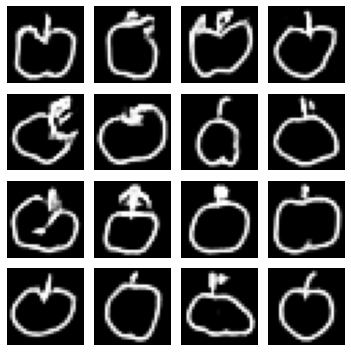

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.644129, acc: 0.651564]  [A loss: 1.296894, acc: 0.140541]


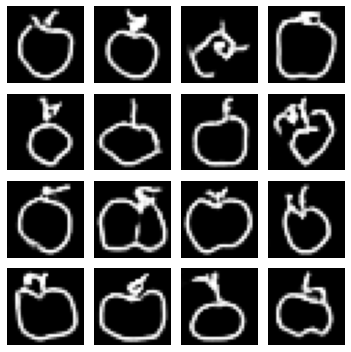

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.640790, acc: 0.656983]  [A loss: 1.349919, acc: 0.138173]


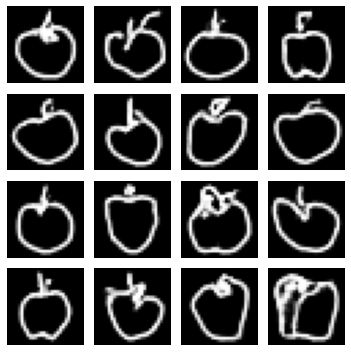

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.640917, acc: 0.660597]  [A loss: 1.409443, acc: 0.137889]


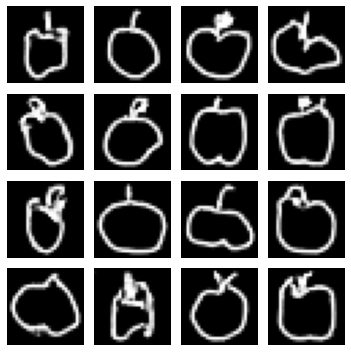

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.640172, acc: 0.663328]  [A loss: 1.448111, acc: 0.137710]


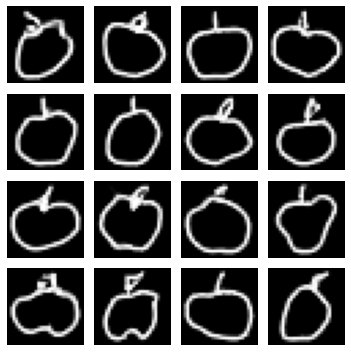

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.639657, acc: 0.664787]  [A loss: 1.467608, acc: 0.137739]


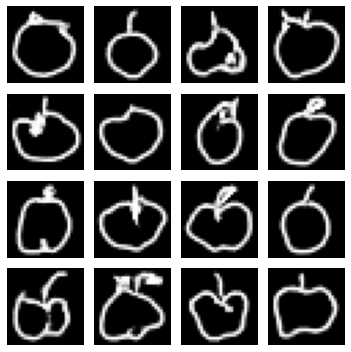

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.639868, acc: 0.665143]  [A loss: 1.479090, acc: 0.138257]


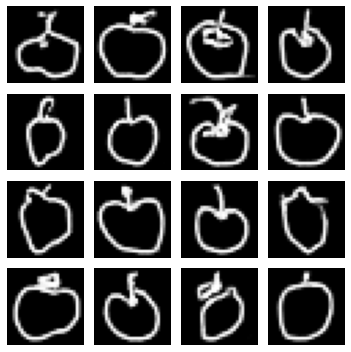

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.640618, acc: 0.664771]  [A loss: 1.477698, acc: 0.138810]


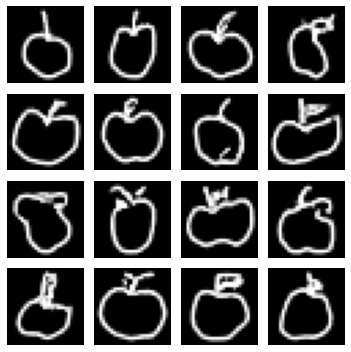

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.641369, acc: 0.664121]  [A loss: 1.468415, acc: 0.139241]


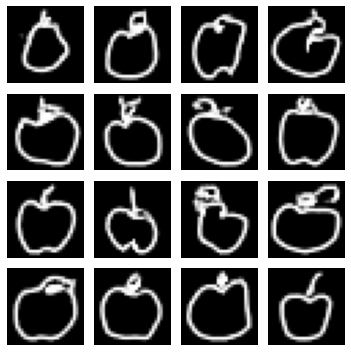

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.642760, acc: 0.663012]  [A loss: 1.456349, acc: 0.139898]


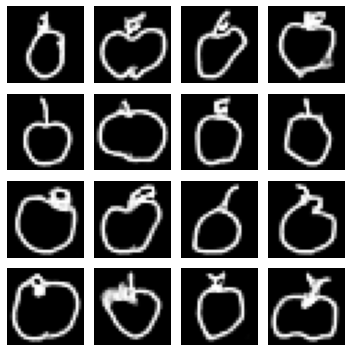

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.644347, acc: 0.661081]  [A loss: 1.437984, acc: 0.141054]


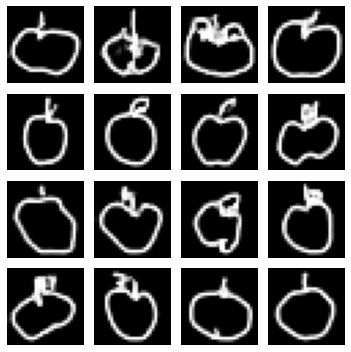

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.646175, acc: 0.658695]  [A loss: 1.416558, acc: 0.141868]


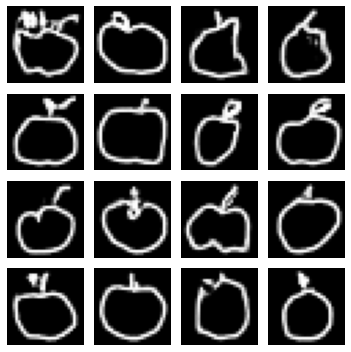

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.648280, acc: 0.656033]  [A loss: 1.394471, acc: 0.143109]


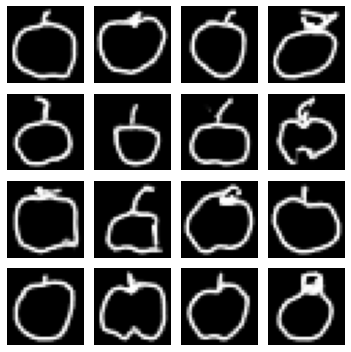

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.650070, acc: 0.653555]  [A loss: 1.372872, acc: 0.144125]


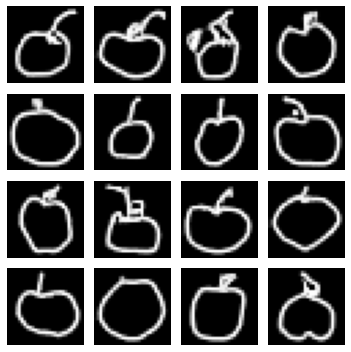

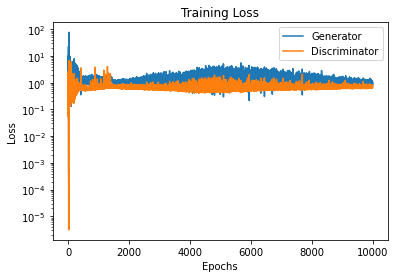

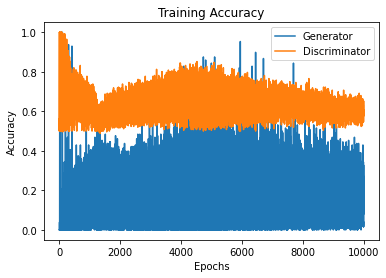

In [11]:
GAN_engine(apple_images)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 256)         0   

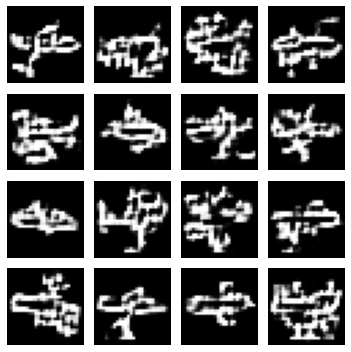

500
600
700
800
900
Epoch #1000
999: [D loss: 0.527267, acc: 0.738864]  [A loss: 1.554949, acc: 0.128543]


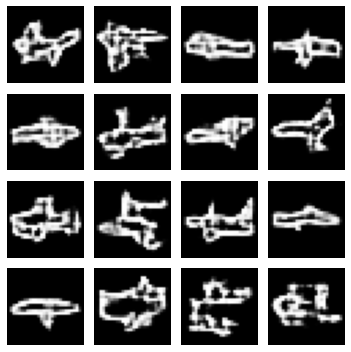

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.555509, acc: 0.720387]  [A loss: 1.519926, acc: 0.123812]


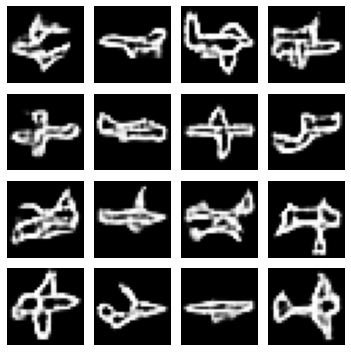

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.570365, acc: 0.712073]  [A loss: 1.511823, acc: 0.121369]


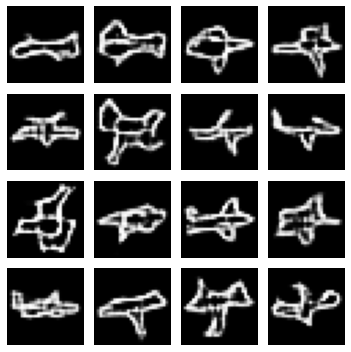

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.578530, acc: 0.708083]  [A loss: 1.515652, acc: 0.120261]


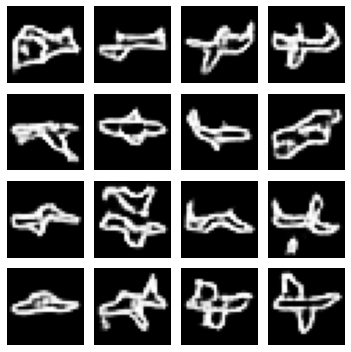

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.580003, acc: 0.707914]  [A loss: 1.528954, acc: 0.120736]


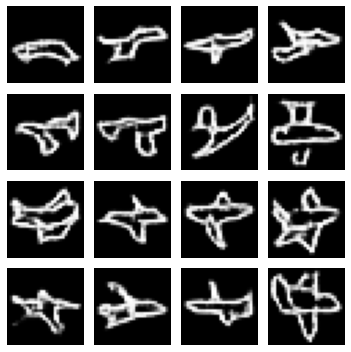

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.581704, acc: 0.708203]  [A loss: 1.568402, acc: 0.120762]


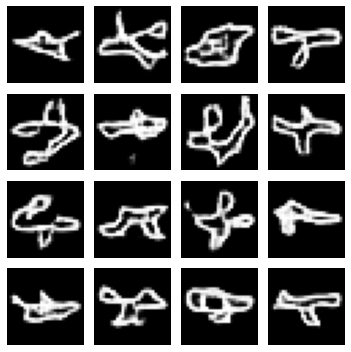

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.580250, acc: 0.710475]  [A loss: 1.609200, acc: 0.119422]


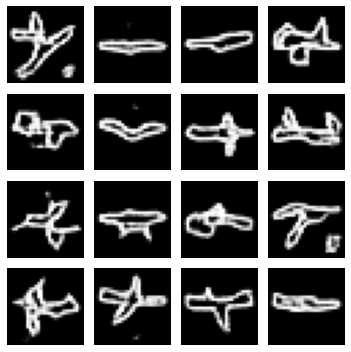

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.578703, acc: 0.712477]  [A loss: 1.643848, acc: 0.118090]


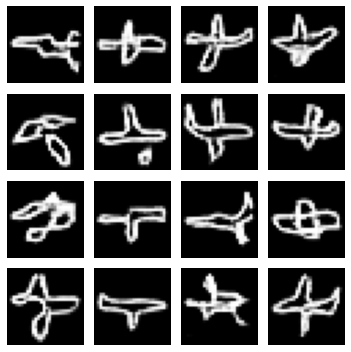

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.578305, acc: 0.713471]  [A loss: 1.656789, acc: 0.117334]


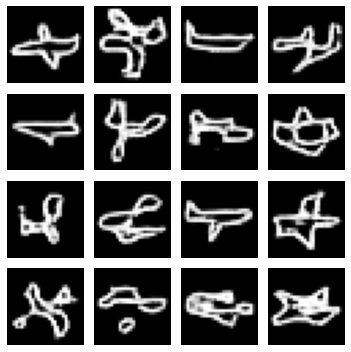

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.579588, acc: 0.713285]  [A loss: 1.646379, acc: 0.116493]


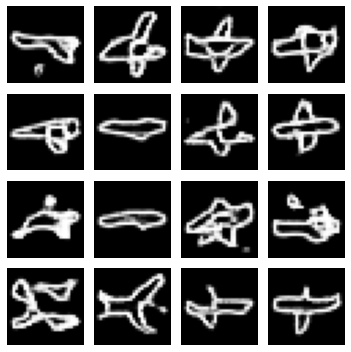

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.581502, acc: 0.712632]  [A loss: 1.628454, acc: 0.115946]


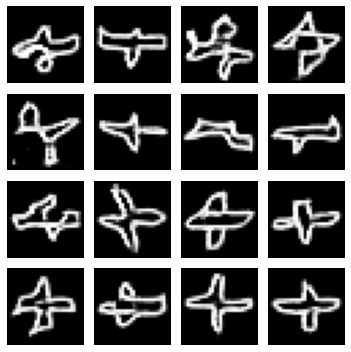

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.583442, acc: 0.711707]  [A loss: 1.611204, acc: 0.115694]


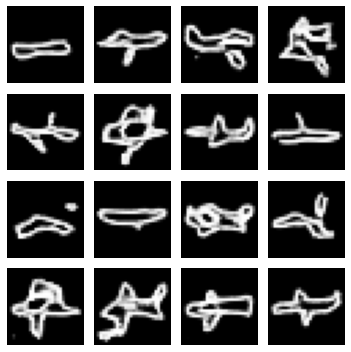

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.585519, acc: 0.711387]  [A loss: 1.599521, acc: 0.115456]


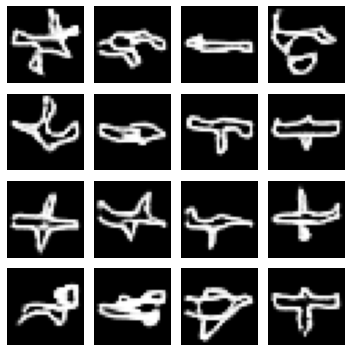

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.586960, acc: 0.710659]  [A loss: 1.579464, acc: 0.115204]


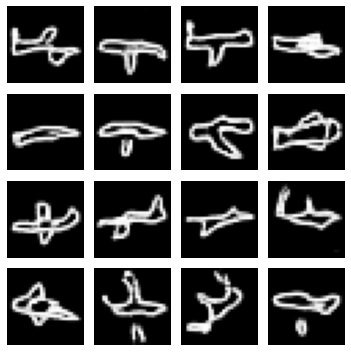

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.589502, acc: 0.709227]  [A loss: 1.555849, acc: 0.115428]


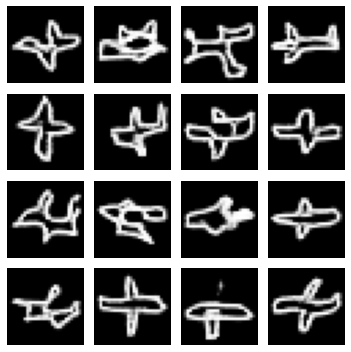

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.591351, acc: 0.708104]  [A loss: 1.536043, acc: 0.115659]


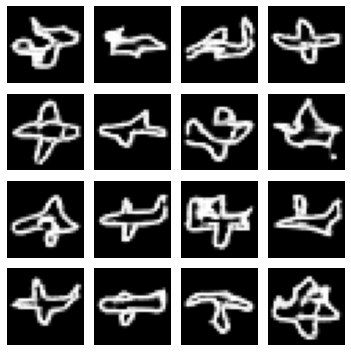

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.592508, acc: 0.707436]  [A loss: 1.519018, acc: 0.115319]


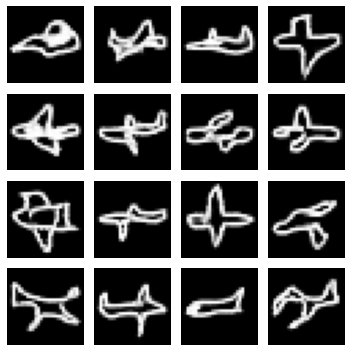

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.594361, acc: 0.706186]  [A loss: 1.502650, acc: 0.115302]


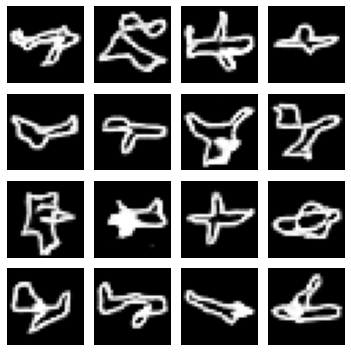

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.596467, acc: 0.704844]  [A loss: 1.487122, acc: 0.115386]


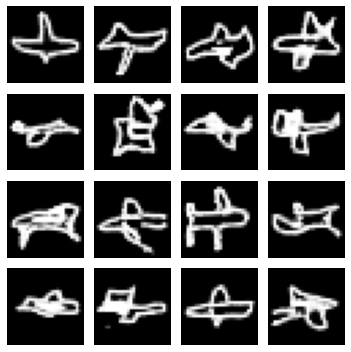

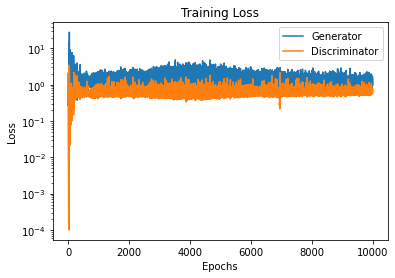

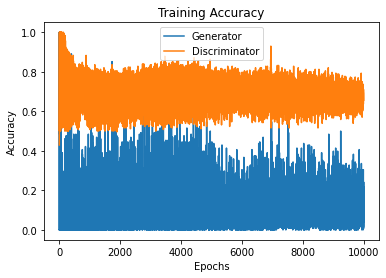

In [12]:
airplane_images = './quickdraw_data/airplane.npy'
GAN_engine(airplane_images)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 256)         0   

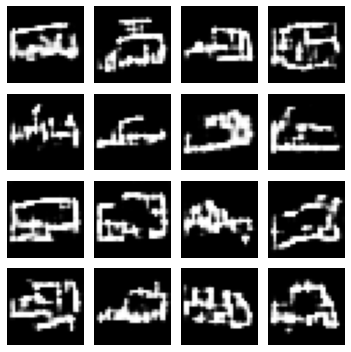

500
600
700
800
900
Epoch #1000
999: [D loss: 0.609459, acc: 0.665228]  [A loss: 1.309026, acc: 0.196939]


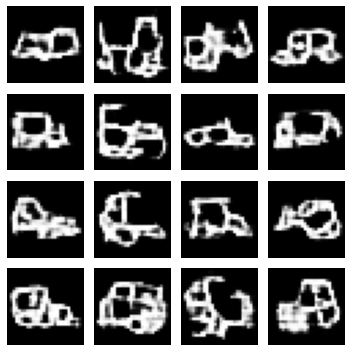

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.619042, acc: 0.660341]  [A loss: 1.295771, acc: 0.182267]


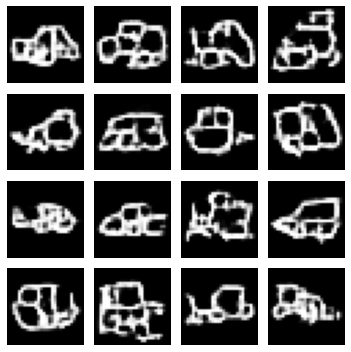

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.624676, acc: 0.662992]  [A loss: 1.386458, acc: 0.173864]


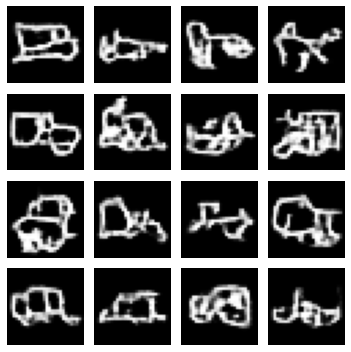

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.621388, acc: 0.669626]  [A loss: 1.475138, acc: 0.166723]


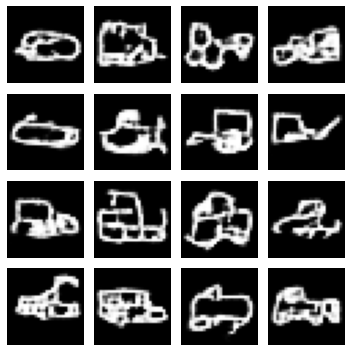

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.617918, acc: 0.675827]  [A loss: 1.549300, acc: 0.160949]


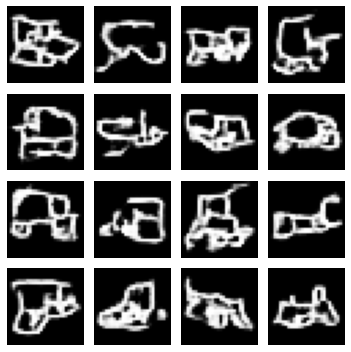

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.613913, acc: 0.680642]  [A loss: 1.586948, acc: 0.156031]


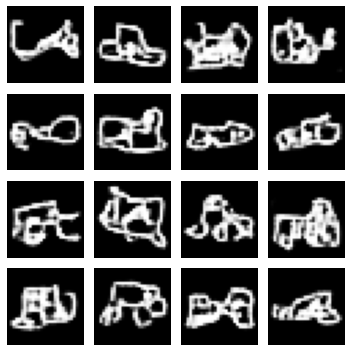

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.612011, acc: 0.683689]  [A loss: 1.593677, acc: 0.151571]


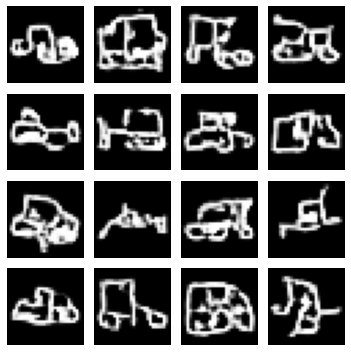

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.609266, acc: 0.686335]  [A loss: 1.597656, acc: 0.147548]


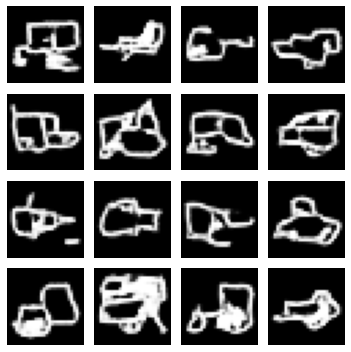

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.607410, acc: 0.688728]  [A loss: 1.600960, acc: 0.142936]


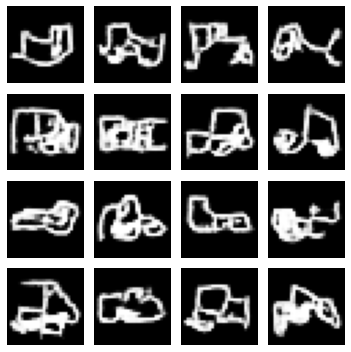

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.607341, acc: 0.690307]  [A loss: 1.588707, acc: 0.139555]


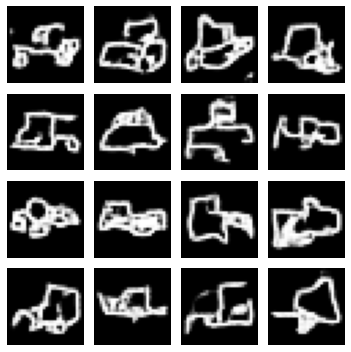

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.606335, acc: 0.692305]  [A loss: 1.580403, acc: 0.136195]


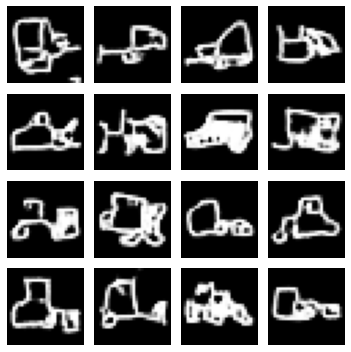

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.607659, acc: 0.692932]  [A loss: 1.561511, acc: 0.134279]


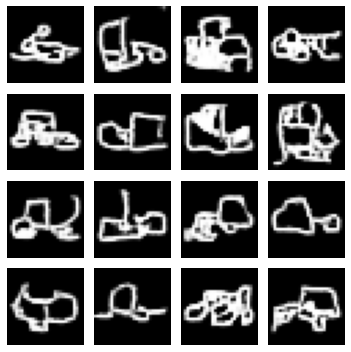

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.608196, acc: 0.694428]  [A loss: 1.543363, acc: 0.131989]


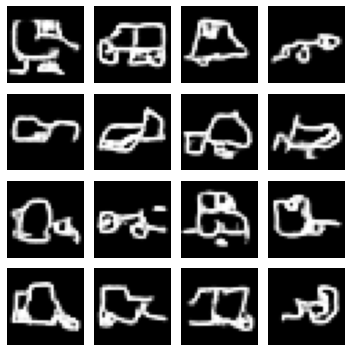

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.608670, acc: 0.695273]  [A loss: 1.522297, acc: 0.130073]


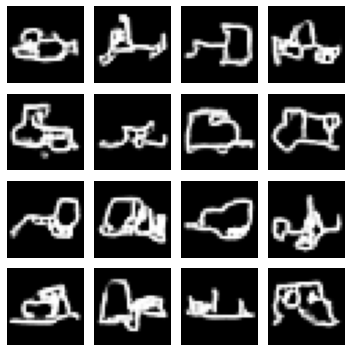

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.610508, acc: 0.695112]  [A loss: 1.490362, acc: 0.128633]


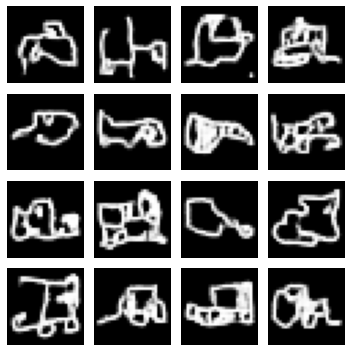

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.611272, acc: 0.695385]  [A loss: 1.458269, acc: 0.127641]


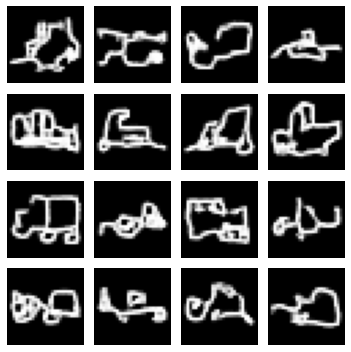

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.611851, acc: 0.695560]  [A loss: 1.429400, acc: 0.127251]


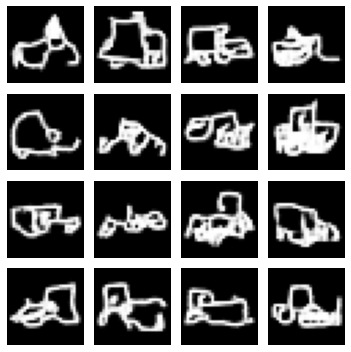

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.612239, acc: 0.695426]  [A loss: 1.404293, acc: 0.127277]


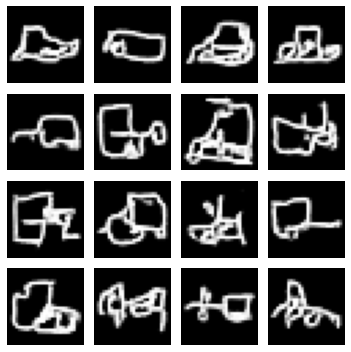

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.611542, acc: 0.696235]  [A loss: 1.387885, acc: 0.126482]


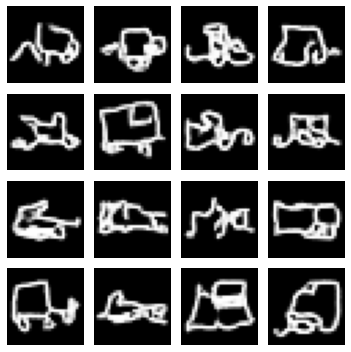

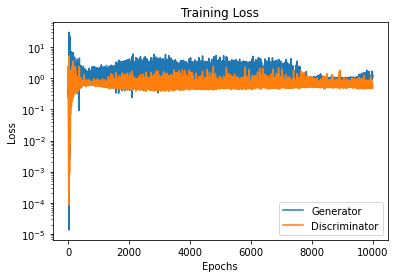

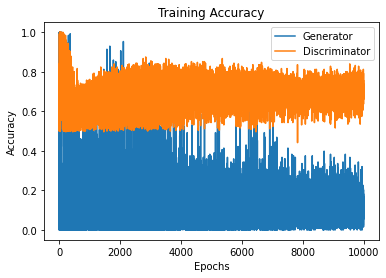

In [13]:
bulldozer_images = './quickdraw_data/bulldozer.npy'
GAN_engine(bulldozer_images)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 4, 256)         0   

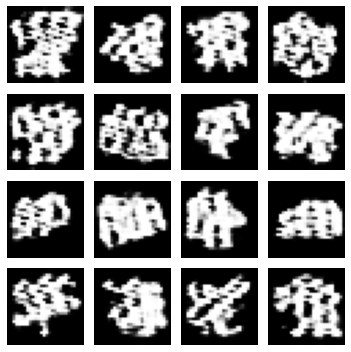

500
600
700
800
900
Epoch #1000
999: [D loss: 0.644807, acc: 0.616535]  [A loss: 1.155067, acc: 0.241914]


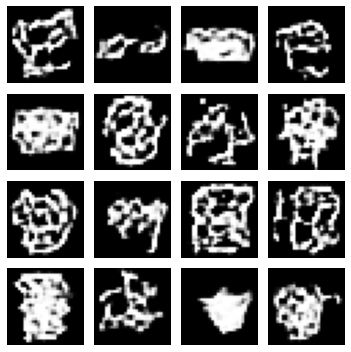

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.661086, acc: 0.595327]  [A loss: 1.039992, acc: 0.242088]


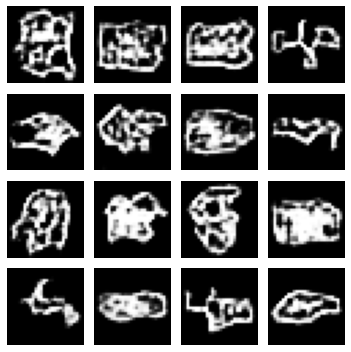

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.668021, acc: 0.590192]  [A loss: 0.995348, acc: 0.237060]


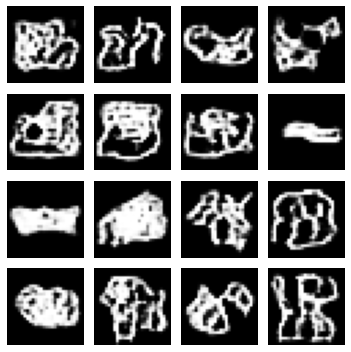

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.673654, acc: 0.587727]  [A loss: 0.963923, acc: 0.237495]


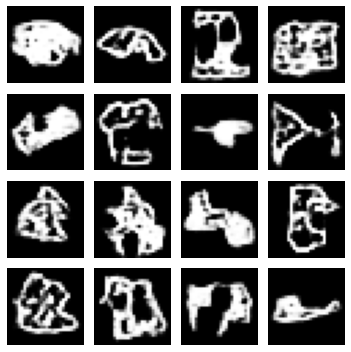

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.680737, acc: 0.583469]  [A loss: 0.934734, acc: 0.240880]


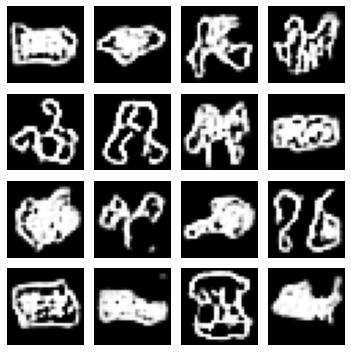

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.688969, acc: 0.574405]  [A loss: 0.911088, acc: 0.237767]


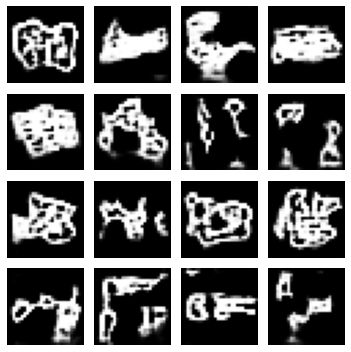

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.693094, acc: 0.567955]  [A loss: 0.894622, acc: 0.228446]


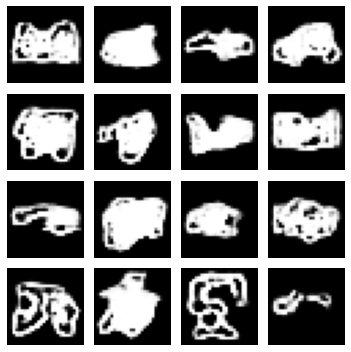

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.695007, acc: 0.565316]  [A loss: 0.878665, acc: 0.229699]


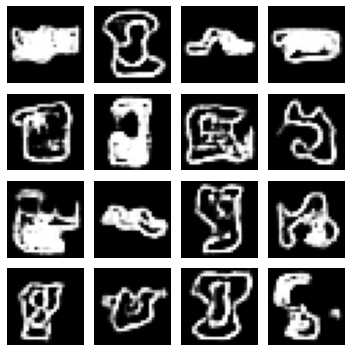

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.697652, acc: 0.562744]  [A loss: 0.866476, acc: 0.227442]


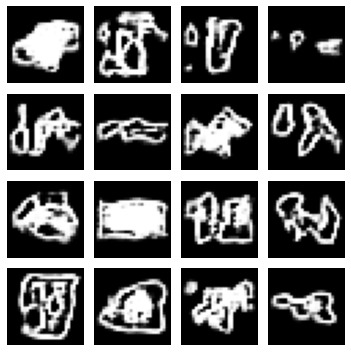

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.699784, acc: 0.558410]  [A loss: 0.856607, acc: 0.223036]


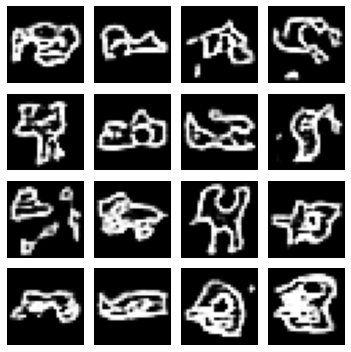

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.701332, acc: 0.555376]  [A loss: 0.847073, acc: 0.220890]


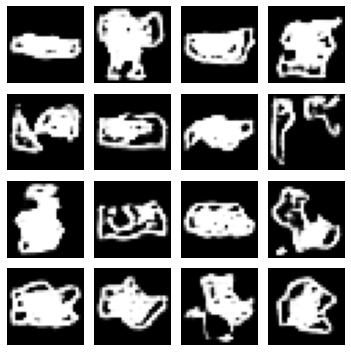

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.702567, acc: 0.552259]  [A loss: 0.838905, acc: 0.218813]


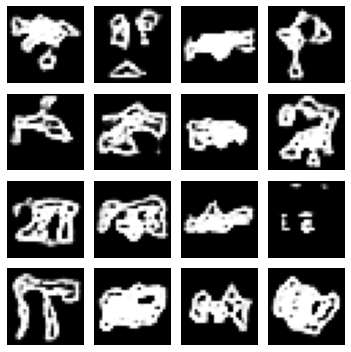

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.703456, acc: 0.549594]  [A loss: 0.830657, acc: 0.211866]


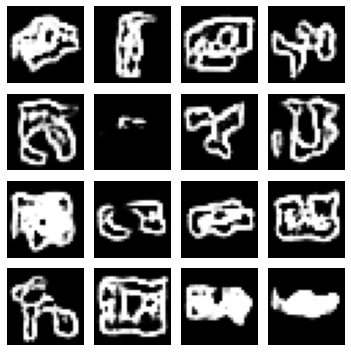

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.703244, acc: 0.546639]  [A loss: 0.821455, acc: 0.237408]


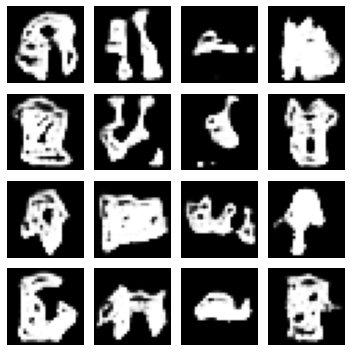

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.702697, acc: 0.543796]  [A loss: 0.813528, acc: 0.249439]


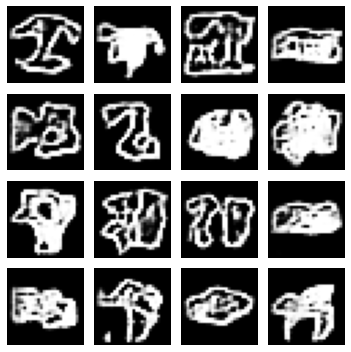

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.702651, acc: 0.541328]  [A loss: 0.805976, acc: 0.275981]


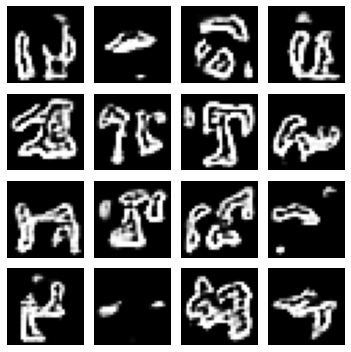

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.702691, acc: 0.539199]  [A loss: 0.799273, acc: 0.298248]


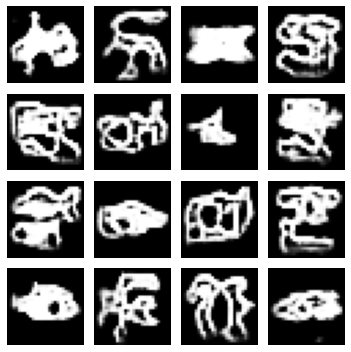

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.702219, acc: 0.537138]  [A loss: 0.793601, acc: 0.319542]


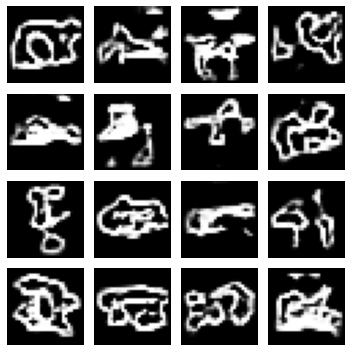

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.703357, acc: 0.535322]  [A loss: 0.788035, acc: 0.346064]


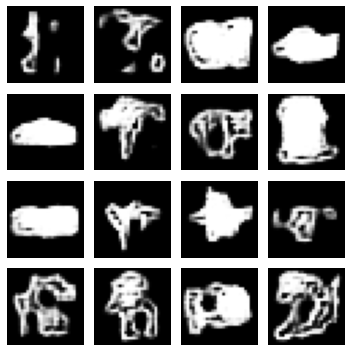

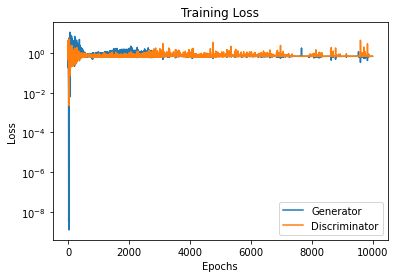

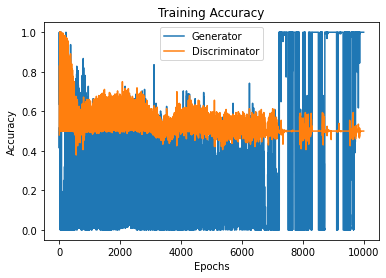

In [14]:
camouflage_images = './quickdraw_data/camouflage.npy'
GAN_engine(camouflage_images)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 4, 256)         0   

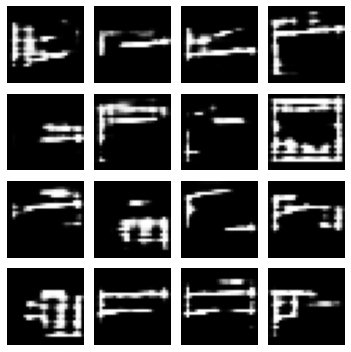

500
600
700
800
900
Epoch #1000
999: [D loss: 0.613166, acc: 0.699301]  [A loss: 1.534261, acc: 0.125805]


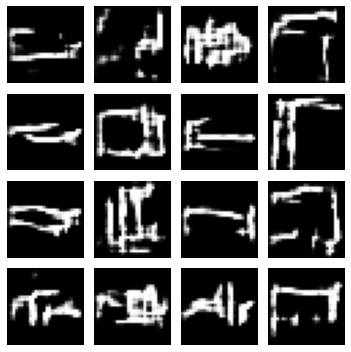

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.608966, acc: 0.693040]  [A loss: 1.521873, acc: 0.120617]


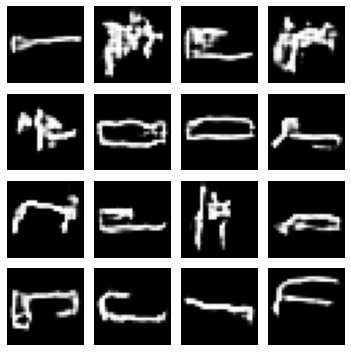

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.609147, acc: 0.692209]  [A loss: 1.581087, acc: 0.117770]


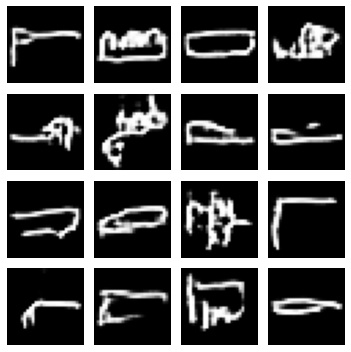

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.605853, acc: 0.693013]  [A loss: 1.598972, acc: 0.115334]


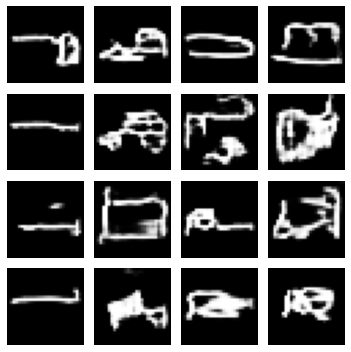

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.604790, acc: 0.692610]  [A loss: 1.608390, acc: 0.114786]


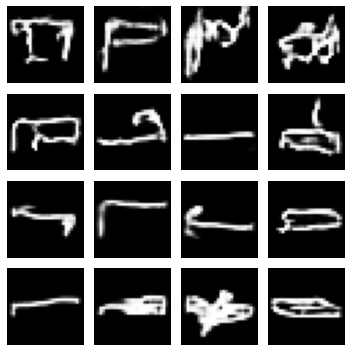

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.602172, acc: 0.694461]  [A loss: 1.613843, acc: 0.112682]


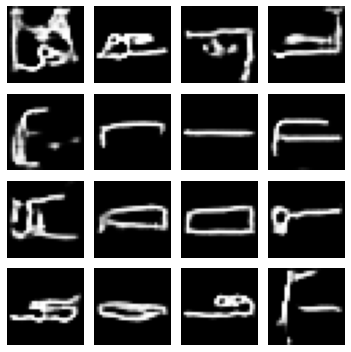

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.597438, acc: 0.697511]  [A loss: 1.617870, acc: 0.110049]


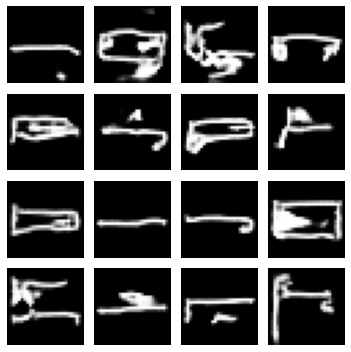

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.595844, acc: 0.698634]  [A loss: 1.606564, acc: 0.108173]


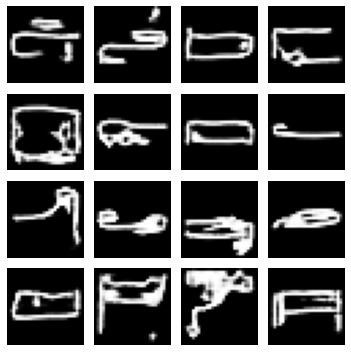

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.595010, acc: 0.699966]  [A loss: 1.590989, acc: 0.106607]


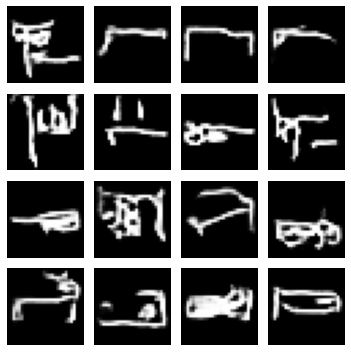

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.591351, acc: 0.702955]  [A loss: 1.567874, acc: 0.103681]


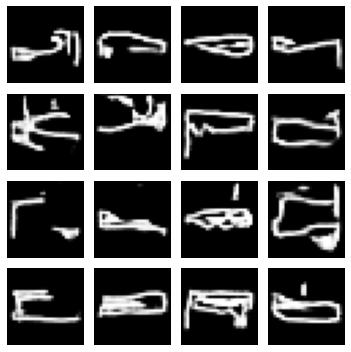

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.588726, acc: 0.705771]  [A loss: 1.547702, acc: 0.100973]


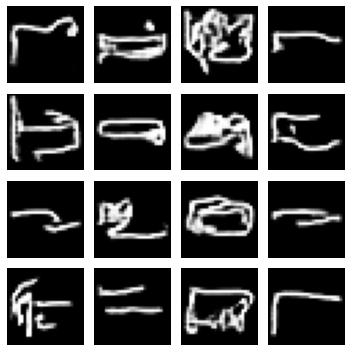

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.587593, acc: 0.707634]  [A loss: 1.521038, acc: 0.098828]


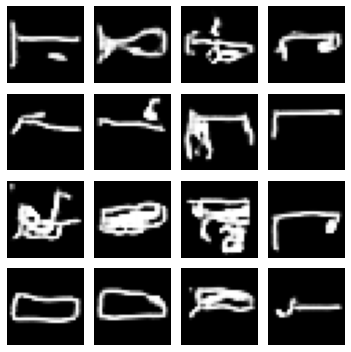

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.586055, acc: 0.709455]  [A loss: 1.498921, acc: 0.097045]


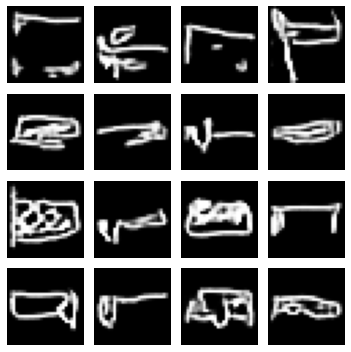

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.585927, acc: 0.710693]  [A loss: 1.474032, acc: 0.095888]


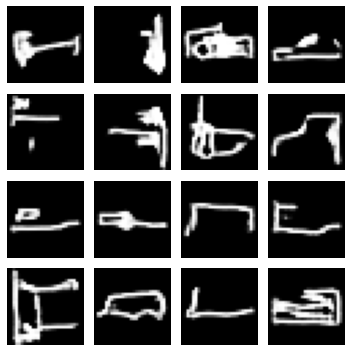

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.585783, acc: 0.711547]  [A loss: 1.451920, acc: 0.094752]


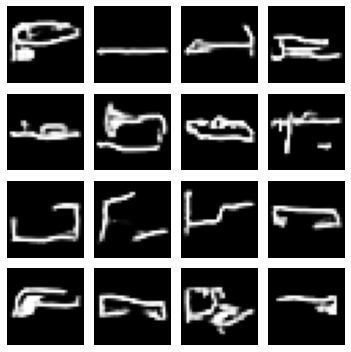

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.585601, acc: 0.712342]  [A loss: 1.431994, acc: 0.093808]


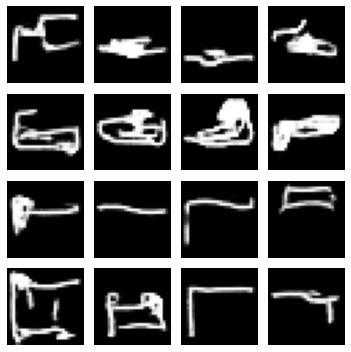

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.585926, acc: 0.712570]  [A loss: 1.414357, acc: 0.093050]


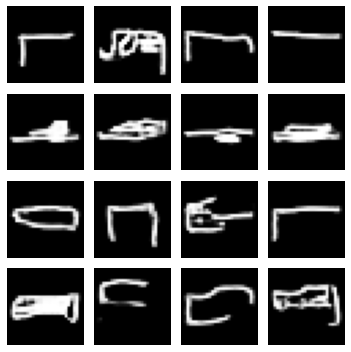

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.585753, acc: 0.713153]  [A loss: 1.400096, acc: 0.092455]


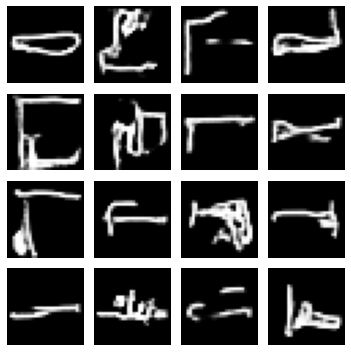

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.586079, acc: 0.713330]  [A loss: 1.387673, acc: 0.092059]


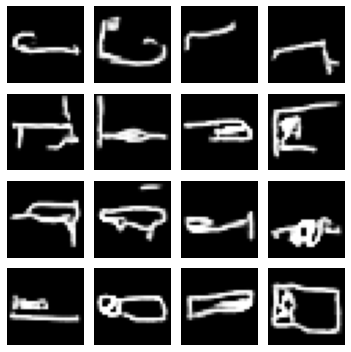

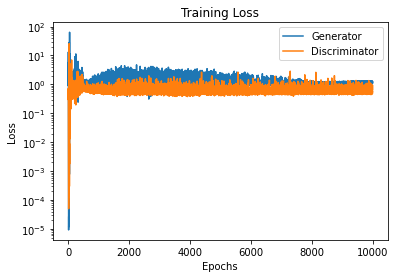

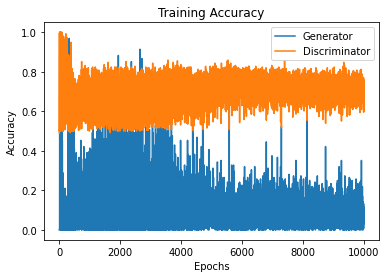

In [15]:
diving_images = './quickdraw_data/diving board.npy'
GAN_engine(diving_images)